### Using LM to find KEY words linear trend fit "flu" best (by paper Using Twitter to Estimate and Predict the Trends and Opinions)
### Applying Gibbs sampling to find coefficients


In [2]:
import tweepy
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import random
from tweepy import Stream
import csv
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from datetime import datetime#
import pymongo
import ipywidgets as wgt
from IPython.display import display
from sklearn.feature_extraction.text import CountVectorizer
import re
import time
%matplotlib inline 

pd.options.display.max_columns = 50
pd.options.display.max_rows = 50
pd.options.display.width = 120

In [3]:
consumer_key = "Your Credential"

consumer_secret = "Your Credential";

access_token = "Your Credential";

access_token_secret = "Your Credential";


auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)

In [4]:
def get_all_tweets(screen_name):
    alltweets = []
    new_tweets = api.user_timeline(screen_name = screen_name,count=200)
    alltweets.extend(new_tweets)
    oldest = alltweets[-1].id - 1
    counter = 0
    while (len(new_tweets) > 0) and (counter < 3):
        counter = counter + 1
        print("getting tweets before %s" % (oldest))
    
        #all subsiquent requests use the max_id param to prevent duplicates
        new_tweets = api.user_timeline(screen_name = screen_name,count=200,max_id=oldest)

        #save most recent tweets
        alltweets.extend(new_tweets)
        
        #update the id of the oldest tweet less one
        oldest = alltweets[-1].id - 1
        
        print("...%s tweets downloaded so far" % (len(alltweets)))

    #transform the tweepy tweets into a 2D array that will populate the csv	
    outtweets = [[tweet.id_str, tweet.created_at, tweet.text.encode("utf-8"), tweet.retweet_count] for tweet in alltweets]
    
    #write the csv	
    with open('%s_tweets.csv' % screen_name, 'w') as f:
        writer = csv.writer(f)
        writer.writerow(["id","created_at","text", "retweet_count"])
        writer.writerows(outtweets)

pass

In [27]:
get_all_tweets("BlairMeadows")

getting tweets before 806147979811913728
...400 tweets downloaded so far
getting tweets before 770664830323847167
...599 tweets downloaded so far
getting tweets before 712054892551131135
...799 tweets downloaded so far


In [28]:
def is_positive(word):
    with open('positive_words.txt') as f:
        found = False
        for line in f:
            if word.upper() in line: # Key line: check if `w` is in the line.
                found = True
                return found 
            else:
                continue
        return False

In [29]:
# flu shot rate NYCREACH_tweets.csv
 
# how many tweets with flu shot, those tweets ID

id_list=[]
created_time_list=[]
text_list=[]
retweet_list = []
        
df = pd.read_csv("BlairMeadows_tweets.csv")

#df = pd.read_csv("Fabian_Peru_retweets.csv")

for i in range(0, df.id.count()):
    if ("flu shot" in df.text[i]):
        id_list.append(df.id[i])
        created_time_list.append(df.created_at[i])
        text_list.append(df.text[1])
        #retweet_list.append(df.retweet_count[i])
    else:
        continue

#print(id_list)
print(retweet_list)
#print(created_time_list)
#print(text_list)
        
# time duration

date_format = "%Y-%m-%d %H:%M:%S"
a = datetime.strptime(df.created_at[0], date_format)
b = datetime.strptime(df.created_at[df.id.count()-1], date_format)
delta = a- b 

# tweets rate by days print('The value of PI is approximately %5.3f.' % math.pi)

print('The retweet_count rate over days is %.4f.' % float((sum(retweet_list))/delta.days)) 

print('The tweets rate over days is %.4f.' % float((len(id_list))/delta.days)) 

# collected tweets with flu shot polarity
positive_count = 0
for i in range(0, (len(id_list))):
    wordList = re.sub("[^\w]", " ", df.text[i]).split()
    for word in wordList: 
        if word.isalpha() and (is_positive(str(word))):
            positive_count = positive_count + 1
print(positive_count)
print('The tweets positive rate over days is %.4f.' % float(positive_count/delta.days))


# collected tweets with flu shot polarity
positive_count = 0
for i in range(0, (df.id.count())):
    wordList = re.sub("[^\w]", " ", df.text[i]).split()
    for word in wordList: 
        if word.isalpha() and (is_positive(str(word))):
            positive_count = positive_count + 1
print(positive_count)
print('The tweets ALL positive rate over days is %.4f.' % float(positive_count/delta.days))



[]
The retweet_count rate over days is 0.0000.
The tweets rate over days is 0.0049.
9
The tweets positive rate over days is 0.0220.
4689
The tweets ALL positive rate over days is 11.4645.


In [87]:
print (delta.days)
print (df.id.count()-1)

1
796


In [5]:
%matplotlib inline
from seaborn import plt
#import pandas as pd
plt.rcParams['figure.figsize'] = (10, 5)

In [6]:
def sample_beta_0(y, x, beta_1, tau, mu_0, tau_0):
    N = len(y)
    assert len(x) == N
    precision = tau_0 + tau * N
    mean = tau_0 * mu_0 + tau * np.sum(y - beta_1 * x)
    mean /= precision
    return np.random.normal(mean, 1 / np.sqrt(precision))

In [7]:
def sample_beta_1(y, x, beta_0, tau, mu_1, tau_1):
    N = len(y)
    assert len(x) == N
    precision = tau_1 + tau * np.sum(x * x)
    mean = tau_1 * mu_1 + tau * np.sum( (y - beta_0) * x)
    mean /= precision
    return np.random.normal(mean, 1 / np.sqrt(precision))

In [8]:
def sample_tau(y, x, beta_0, beta_1, alpha, beta):
    N = len(y)
    alpha_new = alpha + N / 2
    resid = y - beta_0 - beta_1 * x
    beta_new = beta + np.sum(resid * resid) / 2
    return np.random.gamma(alpha_new, 1 / beta_new)

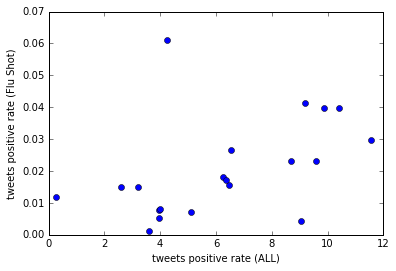

In [3]:
beta_0_true = -1
beta_1_true = 2
tau_true = 1



N = 20
x = [4.2311, 3.9683, 6.4555, 5.0951, 6.234,
     3.9607, 9.0545, 0.2693, 10.3923, 8.702,
     9.1740, 3.6061, 6.5217, 9.8738, 3.189,
     3.9854, 11.5486, 6.345, 2.592, 9.578]
x = np.asarray(x)
y = [0.0612, 0.0053, 0.0156,  0.0073, 0.0181,
     0.0079, 0.0044, 0.0118, 0.0399, 0.023,
     0.0413, 0.0012, 0.0265, 0.0398, 0.015,
     0.0081, 0.0296, 0.0171, 0.0149, 0.0231]
y = np.asarray(y)

synth_plot = plt.plot(x, y, "o")
plt.xlabel("tweets positive rate (ALL)")
plt.ylabel("tweets positive rate (Flu Shot)")

In [16]:
## specify initial values
init = {"beta_0": 0.1,
        "beta_1": 0.1,
        "tau": 2}

## specify hyper parameters
hypers = {"mu_0": 0.1,
         "tau_0": 1,
         "mu_1": 0.1,
         "tau_1": 1,
         "alpha": 2,
         "beta": 1}

In [17]:
def gibbs(y, x, iters, init, hypers):
    assert len(y) == len(x)
    beta_0 = init["beta_0"]
    beta_1 = init["beta_1"]
    tau = init["tau"]
    
    trace = np.zeros((iters, 3)) ## trace to store values of beta_0, beta_1, tau
    
    for it in range(iters):
        beta_0 = sample_beta_0(y, x, beta_1, tau, hypers["mu_0"], hypers["tau_0"])
        beta_1 = sample_beta_1(y, x, beta_0, tau, hypers["mu_1"], hypers["tau_1"])
        tau = sample_tau(y, x, beta_0, beta_1, hypers["alpha"], hypers["beta"])
        trace[it,:] = np.array((beta_0, beta_1, tau))
        
    trace = pd.DataFrame(trace)
    trace.columns = ['beta_0', 'beta_1', 'tau']
        
    return trace

In [19]:
print(x)

[  4.2311   3.9683   6.4555   5.0951   6.234    3.9607   9.0545   0.2693
  10.3923   8.702    9.174    3.6061   6.5217   9.8738   3.189    3.9854
  11.5486   6.345    2.592    9.578 ]


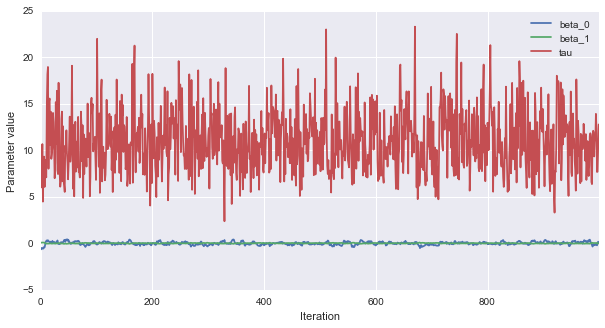

In [18]:
iters = 1000
trace = gibbs(y, x, iters, init, hypers)
traceplot = trace.plot()
traceplot.set_xlabel("Iteration")
traceplot.set_ylabel("Parameter value")

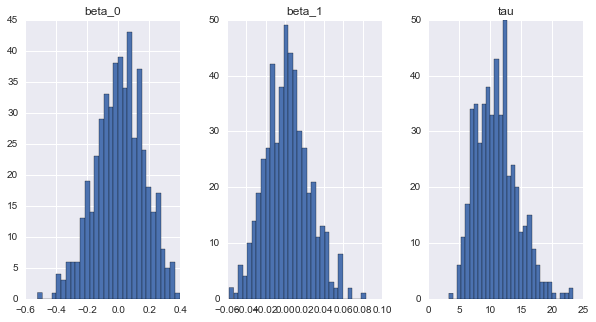

In [20]:
trace_burnt = trace[500:999]
hist_plot = trace_burnt.hist(bins = 30, layout = (1,3))

In [21]:
print(trace_burnt.median())
print(trace_burnt.std())

beta_0     0.014911
beta_1     0.001666
tau       10.797201
dtype: float64
beta_0    0.157283
beta_1    0.022936
tau       3.353728
dtype: float64


In [17]:
beta_0_true = 0.004626
beta_1_true = 0.003416
tau_true = 10.564020
# tweets positive rate in sample period
x = 9.5
y = beta_0_true + beta_1_true * x 
print(y)

0.037078


## Given tweet ID, count ALL positive rate after this tweet for a user


In [22]:
user_screen_name = ['HighestHonor_', 'FHNChicago', 'izzybaeby_',\
                    'projectaccesshc', 'ShadowKat2K', 'lulu111593',\
                    'BlairMeadows', 'dragnesdc', 'supersoul1970', 'RoopawcalypseAD']
tweets_ID = [840438728397082624, 840438702979473408, 840436438105706497,\
             840435185380282368, 840371731273515008, 840369198392008704,\
             840362389874868225, 840352545100910593, 840349682228387840, 840232127232909312]
index = 8
screen_name_s = "RoopawcalypseAD"
tweet_id = 840232127232909312

new_tweets = api.user_timeline(screen_name = screen_name_s,\
                               since_id = tweet_id, count=200)

outtweets = [[tweet.id_str, tweet.created_at, \
              tweet.text.encode("utf-8"), tweet.retweet_count] for tweet in new_tweets]
 

with open('%s_tweets_in_sample.csv' % screen_name_s, 'w') as f:
        writer = csv.writer(f)
        writer.writerow(["id","created_at","text", "retweet_count"])
        writer.writerows(outtweets)
        
file =str(screen_name_s)  + "_tweets_in_sample.csv"
df = pd.read_csv(file)
date_format = "%Y-%m-%d %H:%M:%S"

a = datetime.strptime(df.created_at[0], date_format)
b = datetime.strptime(df.created_at[df.id.count()-1], date_format)
delta = a- b 
#print(delta.days)

id_list=[]
created_time_list=[]
text_list=[]
retweet_list = []
        

for i in range(0, df.id.count()):
    if ("flu shot" in df.text[i]):
        id_list.append(df.id[i])
        created_time_list.append(df.created_at[i])
        text_list.append(df.text[1])
        #retweet_list.append(df.retweet_count[i])
    else:
        continue


print('The retweet_count rate over days is %.4f.' % float((sum(retweet_list))/delta.days)) 

print('The tweets rate over days is %.4f.' % float((len(id_list))/delta.days)) 

# collected tweets with flu shot polarity
positive_count = 0
for i in range(0, (len(id_list))):
    wordList = re.sub("[^\w]", " ", df.text[i]).split()
    for word in wordList: 
        if word.isalpha() and (is_positive(str(word))):
            positive_count = positive_count + 1
print(positive_count)
print('The tweets positive rate over days is %.4f.' % float(positive_count/delta.days))


# collected tweets with flu shot polarity
positive_count = 0
for i in range(0, (df.id.count())):
    wordList = re.sub("[^\w]", " ", df.text[i]).split()
    for word in wordList: 
        if word.isalpha() and (is_positive(str(word))):
            positive_count = positive_count + 1
print(positive_count)
print('The tweets positive rate over days is (By Gibbs) %.4f.' % \
      float( beta_0_true + (beta_1_true * positive_count / delta.days)))


The retweet_count rate over days is 0.0000.
The tweets rate over days is 0.0000.
0
The tweets positive rate over days is 0.0000.
54
The tweets positive rate over days is (By Gibbs) 0.0969.
